In [25]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
print(os.getcwd())
%matplotlib inline
import shutil
import pandas as pd
import matplotlib
from torchvision import datasets
from torch.utils.data import DataLoader
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import torch.nn.functional as F
from tqdm import tqdm
import torchvision.models as models
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision.transforms import v2
from PIL import Image
from torchvision import transforms
import matplotlib as mpl
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.nn as nn
import torch.optim as optim
from torchvision.models import densenet121, DenseNet121_Weights

C:\Users\Georgelele\PycharmProjects\Comp9444Proj1


In [38]:
 # the original dataset
src_root = os.path.join(os.getcwd(), "C:\\Users\\Georgelele\\Downloads\\EBH-HE-IDS\\ColHis-IDS")
# a midway dataset that stores its metadata information in a pandas dataframe
dst_root = os.path.join(os.getcwd(), "grouped_ds")

os.makedirs(dst_root, exist_ok=True)

df = pd.DataFrame()

for class_name in os.listdir(src_root):
    class_path = os.path.join(src_root, class_name)
    for root, dirs, files in os.walk(class_path):
        if len(dirs) == 0:
            magnification = int(list(root.split('\\'))[-1])
            instance = list(root.split('\\'))[-2]

            for i in range(len(files)):
                file_name = f'{class_name}_{magnification}_{instance}_{i}.jpg'
                data = pd.DataFrame([{
                    'class': class_name,
                    'magnification': magnification,
                    'file name': file_name
                }])
                df = pd.concat([df, data]).reset_index(drop=True)

                src_file = os.path.join(root, files[i])
                dst_file = os.path.join(dst_root, file_name)
                shutil.copy2(src_file, dst_file)

df.to_csv('metadata.csv')

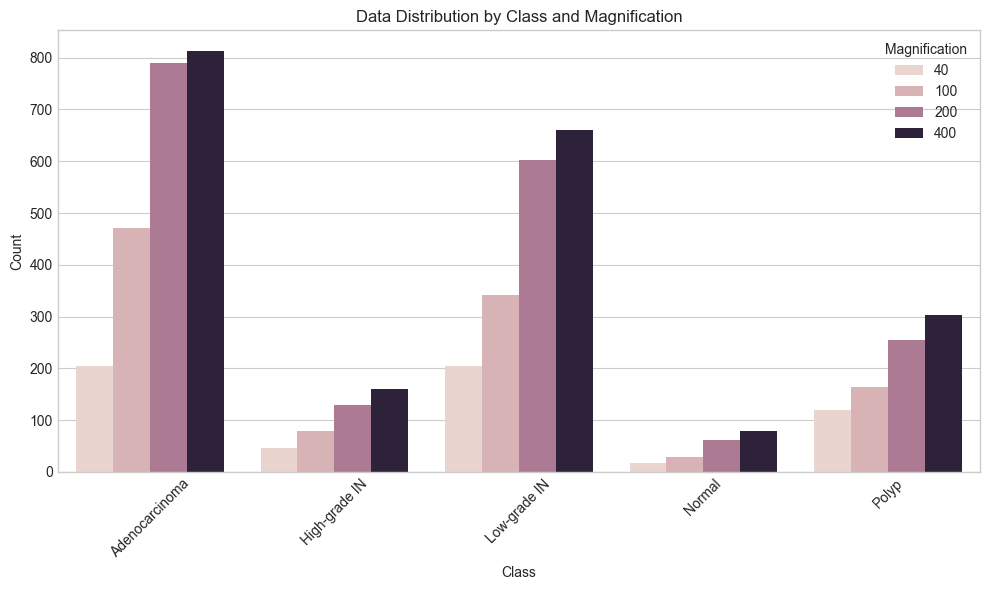

In [39]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="class", hue="magnification")
plt.title("Data Distribution by Class and Magnification")
plt.xlabel("Class")
plt.ylabel("Count")
plt.legend(title="Magnification")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [40]:
src_root = os.path.join(os.getcwd(), "grouped_ds")
dst_root = os.path.join(os.getcwd(), "datasetrebased")

df = pd.read_csv("metadata.csv")

# can manipulate data below if needed - change the class distribution etc
# split dataset into train, val, test sets (80/10/10)
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class'], random_state=42)

splits = {
    'train': train_df,
    'val': val_df,
    'test': test_df
}

for split_name, split_df in splits.items():
    for class_name in np.unique(split_df['class']):
        class_data = split_df[split_df['class'] == class_name]

        class_folder = os.path.join(dst_root, split_name, class_name)
        os.makedirs(class_folder, exist_ok=True)

        for file_name in class_data['file name'].values:
            src_file = os.path.join(src_root, file_name)
            dst_file = os.path.join(class_folder, file_name)
            shutil.copy2(src_file, dst_file)

In [41]:
df

,Unnamed: 0,class,magnification,file name
0,0,Adenocarcinoma,100,Adenocarcinoma_100_20201113-2013084-1_0.jpg
1,1,Adenocarcinoma,100,Adenocarcinoma_100_20201113-2013084-1_1.jpg
2,2,Adenocarcinoma,100,Adenocarcinoma_100_20201113-2013084-1_2.jpg
3,3,Adenocarcinoma,100,Adenocarcinoma_100_20201113-2013084-1_3.jpg
4,4,Adenocarcinoma,100,Adenocarcinoma_100_20201113-2013084-1_4.jpg
...,...,...,...,...
5527,5527,Polyp,200,Polyp_200_20210711-XC2015381-1_2.jpg
5528,5528,Polyp,200,Polyp_200_20210711-XC2015381-1_3.jpg
5529,5529,Polyp,400,Polyp_400_20210711-XC2015381-1_0.jpg
5530,5530,Polyp,400,Polyp_400_20210711-XC2015381-1_1.jpg


loss function

In [54]:
# -----------------------------
# Loss functions
# -----------------------------
def dice_loss(pred, target, epsilon=1e-6):
    pred = torch.softmax(pred, dim=1)
    target = F.one_hot(target, num_classes=pred.size(1)).permute(0, 3, 1, 2).float() \
        if target.ndim == 3 else F.one_hot(target, num_classes=pred.size(1)).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return 1 - (2. * intersection + epsilon) / (union + epsilon)

def focal_loss(pred, target, alpha=0.75, gamma=2):
    ce_loss = F.cross_entropy(pred, target, reduction='none')
    pt = torch.exp(-ce_loss)
    focal = alpha * (1 - pt) ** gamma * ce_loss
    return focal.mean()

def tversky_loss(pred, target, alpha=0.7, beta=0.3, epsilon=1e-6):
    pred = torch.softmax(pred, dim=1)
    target = F.one_hot(target, num_classes=pred.size(1)).float()
    tp = (pred * target).sum()
    fp = ((1 - target) * pred).sum()
    fn = (target * (1 - pred)).sum()
    return 1 - (tp + epsilon) / (tp + alpha * fp + beta * fn + epsilon)

def combo_loss(pred, target):
    return 0.5 * focal_loss(pred, target) + 0.5 * dice_loss(pred, target)

def focal_tversky_combo(pred, target):
    return 0.5 * focal_loss(pred, target) + 0.5 * tversky_loss(pred, target)

def select_loss(loss_type):
    if loss_type == "dice":
        return dice_loss
    elif loss_type == "focal":
        return focal_loss
    elif loss_type == "tversky":
        return tversky_loss
    elif loss_type == "focal+dice":
        return combo_loss
    elif loss_type == "focal+tversky":
        return focal_tversky_combo
    else:
        raise ValueError(f"Unsupported loss function: {loss_type}")


resnet50

In [55]:
# -----------------------------
# resnet50
# -----------------------------
def get_resnet_classifier(num_classes=5, pretrained=True):
    model = models.resnet50(weights="IMAGENET1K_V1" if pretrained else None)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

Densenet

In [56]:
def get_densenet_classifier(num_classes=5, pretrained=True):
    weights = DenseNet121_Weights.IMAGENET1K_V1 if pretrained else None
    model = densenet121(weights=weights)
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, num_classes)
    return model

EfficientNet

In [57]:
def get_efficientnet_classifier(num_classes=5, pretrained=True):
    weights = EfficientNet_B0_Weights.IMAGENET1K_V1 if pretrained else None
    model = efficientnet_b0(weights=weights)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)
    return model

Metrics Plotting

In [58]:
# -----------------------------
# Metrics Plotting
# -----------------------------
def plot_metrics(history, save_dir=None, show_inline=True):
    epochs = range(1, len(history["acc"]) + 1)
    plt.figure()
    plt.plot(epochs, history["acc"], label="Accuracy")
    plt.plot(epochs, history["precision"], label="Precision")
    plt.plot(epochs, history["recall"], label="Recall")
    plt.plot(epochs, history["f1"], label="F1-score")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("Validation Metrics Over Epochs")
    plt.legend()
    plt.grid(True)
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, "metrics_curve.png"))
    if show_inline:
        plt.show()
    plt.close()


def plot_per_class_metrics(history, class_names, save_dir=None, show_inline=True):
    epochs = range(1, len(history["acc"]) + 1)

    for metric in ["precision", "recall", "f1"]:
        plt.figure(figsize=(8, 6))
        for i, cls_name in enumerate(class_names):
            plt.plot(epochs, history["per_class"][i][metric], label=cls_name)
        plt.xlabel("Epoch")
        plt.ylabel(metric.capitalize())
        plt.title(f"Per-Class {metric.capitalize()} Over Epochs")
        plt.legend()
        plt.grid(True)
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            plt.savefig(os.path.join(save_dir, f"per_class_{metric}.png"))
        if show_inline:
            plt.show()
        plt.close()


def plot_confusion(y_true, y_pred, class_names, save_dir=None, show_inline=True):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, "confusion_matrix.png"))
    if show_inline:
        plt.show()
    plt.close()


Training Loop

In [65]:
# -----------------------------
# Training Loop with Args
# -----------------------------
def train_model(model, train_loader, val_loader, device, args, class_names):
    model = model.to(device)

    # ✅ Select optimizer based on args
    if args.optimizer == "adam":
        optimizer = optim.Adam(model.parameters(), lr=args.lr)
    elif args.optimizer == "adamw":
        optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=1e-4)
    elif args.optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=1e-4)
    else:
        raise ValueError(f"Unsupported optimizer: {args.optimizer}")

    # ✅ Select loss from args
    loss_fn = select_loss(args.loss)

    history = {
        "acc": [], "precision": [], "recall": [], "f1": [],
        "per_class": {i: {"precision": [], "recall": [], "f1": []} for i in range(len(class_names))}
    }

    best_acc = 0
    best_y_true, best_y_pred = [], []  # ✅ store best predictions

    for epoch in range(args.epochs):
        # -----------------------------
        # Training
        # -----------------------------
        model.train()
        total_loss, correct, total = 0, 0, 0
        pbar = tqdm(train_loader,
            desc=f"Epoch {epoch + 1}/{args.epochs} [Train]",
            unit="batch",
            leave=False)  # ✅ DON'T leave previous bars on screen
        for imgs, labels in pbar:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
    
            total_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
            pbar.set_postfix({"loss": f"{loss.item():.4f}", "acc": f"{(correct / total):.4f}"})
    
        train_acc = correct / total
        print(f"[Train] Epoch {epoch+1}: Loss={total_loss/total:.4f}, Acc={train_acc:.4f}")
    
        # -----------------------------
        # Validation
        # -----------------------------
        model.eval()
        y_true, y_pred = [], []
        val_loss, val_correct, val_total = 0, 0, 0
        pbar_val = tqdm(val_loader,
                desc=f"Epoch {epoch + 1}/{args.epochs} [Val]",
                unit="batch",
                leave=False)
        with torch.no_grad():
            for imgs, labels in pbar_val:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = loss_fn(outputs, labels)
    
                preds = outputs.argmax(1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
    
                val_loss += loss.item() * labels.size(0)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
    
                pbar_val.set_postfix({"loss": f"{loss.item():.4f}",
                                      "acc": f"{(val_correct / val_total):.4f}"})


        # -----------------------------
        # Metrics Calculation
        # -----------------------------
        precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
            y_true, y_pred, labels=list(range(len(class_names))), average="macro", zero_division=0
        )
        acc = np.mean(np.array(y_true) == np.array(y_pred))
        history["acc"].append(acc)
        history["precision"].append(precision_macro)
        history["recall"].append(recall_macro)
        history["f1"].append(f1_macro)

        precision_cls, recall_cls, f1_cls, _ = precision_recall_fscore_support(
            y_true, y_pred, labels=list(range(len(class_names))), zero_division=0
        )
        for i, cls_name in enumerate(class_names):
            history["per_class"][i]["precision"].append(precision_cls[i])
            history["per_class"][i]["recall"].append(recall_cls[i])
            history["per_class"][i]["f1"].append(f1_cls[i])

        print(f"[Val] Epoch {epoch+1}: Acc={acc:.4f}, Precision={precision_macro:.4f}, "
              f"Recall={recall_macro:.4f}, F1={f1_macro:.4f}")

        # ✅ Save best model & predictions
        if acc > best_acc:
            best_acc = acc
            best_y_true = y_true.copy()
            best_y_pred = y_pred.copy()
            os.makedirs(args.save_dir, exist_ok=True)
            torch.save(model.state_dict(), os.path.join(args.save_dir, "best_model.pth"))
            print(f"✅ Best model updated at epoch {epoch+1} with Acc={acc:.4f}")

    # -----------------------------
    # Plot results after training
    # -----------------------------
    plot_metrics(history, args.save_dir)
    plot_per_class_metrics(history, class_names)
    plot_confusion("Best Val", best_y_true, best_y_pred, class_names)


Args

In [66]:
import argparse, sys, torch

def get_args():
    parser = argparse.ArgumentParser(description="Train ResNet Classifier on Custom Dataset")
    parser.add_argument("--data_dir", type=str, required=True, help="Path to dataset")
    parser.add_argument("--model", type=str, default="resnet",
                    choices=["resnet", "densenet"],
                    help="Model architecture to use")
    parser.add_argument("--epochs", type=int, default=50, help="Number of training epochs")
    parser.add_argument("--batch_size", type=int, default=16, help="Batch size for training")
    parser.add_argument("--lr", type=float, default=1e-4, help="Learning rate")
    parser.add_argument("--optimizer", type=str, default="adamw", 
                        choices=["adam", "adamw", "sgd"], help="Optimizer type")
    parser.add_argument("--loss", type=str, default="focal+tversky",
                        choices=["dice", "focal", "tversky", "focal+dice", "focal+tversky"],
                        help="Loss function")
    parser.add_argument("--img_size", type=int, default=224, help="Input image size (square)")
    parser.add_argument("--num_workers", type=int, default=4, help="Number of DataLoader workers")
    parser.add_argument("--save_dir", type=str, default="results", help="Directory to save outputs")
    parser.add_argument("--device", type=str, default="cuda" if torch.cuda.is_available() else "cpu",
                        help="Training device")
    
    args = parser.parse_args(sys.argv[1:])  # works in Jupyter after cleaning sys.argv in launcher
    return args


Plot

In [67]:
# -----------------------------
# Plotting
# -----------------------------
def plot_global(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Loss Curve
    plt.figure()
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'],   label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Accuracy Curve
    plt.figure()
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'],   label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_per_class_metrics(history, class_names):
    epochs = range(1, len(history["acc"]) + 1)

    for metric in ["precision", "recall", "f1"]:
        plt.figure(figsize=(8, 6))
        for i, cls_name in enumerate(class_names):
            plt.plot(epochs, history["per_class"][i][metric], marker='o', label=cls_name)
        plt.xlabel("Epoch")
        plt.ylabel(metric.capitalize())
        plt.title(f"{metric.capitalize()} Per Class Over Epochs")
        plt.legend()
        plt.grid(True)
        plt.show()  # inline display


def plot_confusion(name, y_true, y_pred, classes, save_dir=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(len(classes) * 1.2, len(classes) * 1.2))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix ({name})')
    
    if save_dir:  
        # If a save_dir is provided, optionally save as well
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, f'confusion_{name}.png'))
    
    plt.show()  # Always display inline
    plt.close()


In [68]:
def main():
    args = get_args()

    run_name = f"{args.model}_epochs{args.epochs}_bs{args.batch_size}_lr{args.lr}_loss{args.loss}_img{args.img_size}"
    run_name = run_name.replace("+", "_")  # ✅ sanitize for Windows paths
    args.save_dir = os.path.join(args.save_dir, run_name)
    os.makedirs(args.save_dir, exist_ok=True)

    if not os.path.isdir(args.data_dir):
        raise RuntimeError(f"❌ Dataset path not found: {args.data_dir}")
    print("✅ Using dataset:", args.data_dir)

    transform = transforms.Compose([
        transforms.Resize((args.img_size, args.img_size)),
        transforms.ToTensor(),
    ])

    train_data = datasets.ImageFolder(os.path.join(args.data_dir, "train"), transform=transform)
    val_data   = datasets.ImageFolder(os.path.join(args.data_dir, "val"), transform=transform)

    train_loader = DataLoader(train_data,
                              batch_size=args.batch_size,
                              shuffle=True,
                              num_workers=args.num_workers,
                              pin_memory=True)

    val_loader = DataLoader(val_data,
                            batch_size=args.batch_size,
                            shuffle=False,
                            num_workers=args.num_workers,
                            pin_memory=True)

    class_names = train_data.classes
    print("Classes:", class_names)

    device = torch.device(args.device)
    model_type = args.model.lower()

    if model_type == "resnet":
        model = get_resnet_classifier(num_classes=len(class_names))
    elif model_type == "densenet":
        model = get_densenet_classifier(num_classes=len(class_names))
    elif model_type == "efficientnet":
        model = get_efficientnet_classifier(num_classes=len(class_names))
    else:
        raise ValueError(f"❌ Unsupported model: {model_type}")

    print(f"🧠 Training {model_type.upper()} | Loss: {args.loss}")
    train_model(model, train_loader, val_loader, device, args, class_names)


In [ ]:
import sys, os

# clear Jupyter's own args
sys.argv = sys.argv[:1]

dataset_path = os.path.abspath(os.path.join(os.getcwd(), "dataset"))
if not os.path.isdir(dataset_path):
    raise RuntimeError(f"❌ Dataset folder not found at {dataset_path}")

sys.argv += [
    "--data_dir", dataset_path,
    "--epochs", "50",
    "--batch_size", "8",
    "--lr", "5e-4",
    "--img_size", "512",
    "--optimizer", "adamw",
    "--num_workers", "4",
    "--save_dir", "runs",
    "--loss", "focal+dice",  # ✅ matches parser
]

print("Launching with:", sys.argv[1:])
main()


Launching with: ['--data_dir', 'C:\\Users\\Georgelele\\PycharmProjects\\Comp9444Proj1\\dataset', '--epochs', '50', '--batch_size', '8', '--lr', '5e-4', '--img_size', '512', '--optimizer', 'adamw', '--num_workers', '4', '--save_dir', 'runs', '--loss', 'focal+dice']
✅ Using dataset: C:\Users\Georgelele\PycharmProjects\Comp9444Proj1\dataset
Classes: ['Adenocarcinoma', 'High-grade IN', 'Low-grade IN', 'Normal', 'Polyp']
🧠 Training RESNET | Loss: focal+dice


[Train] Epoch 1: Loss=0.3838, Acc=0.7081


[Val] Epoch 1: Acc=0.7836, Precision=0.5508, Recall=0.5513, F1=0.5285
✅ Best model updated at epoch 1 with Acc=0.7836


Epoch 2/50 [Train]:  81%|████████  | 446/553 [00:54<00:10, 10.53batch/s, loss=0.2003, acc=0.7774]

In [ ]:
import sys, os

# clear Jupyter's own args
sys.argv = sys.argv[:1]

dataset_path = os.path.abspath(os.path.join(os.getcwd(), "datasetrebased"))
if not os.path.isdir(dataset_path):
    raise RuntimeError(f"❌ Dataset folder not found at {dataset_path}")

sys.argv += [
    "--data_dir", dataset_path,
    "--epochs", "50",
    "--batch_size", "8",
    "--lr", "5e-4",
    "--img_size", "512",
    "--optimizer", "adamw",
    "--num_workers", "4",
    "--save_dir", "runs",
    "--loss", "focal+dice",  # ✅ matches parser
]

print("Launching with:", sys.argv[1:])
main()


Launching with: ['--data_dir', 'C:\\Users\\Georgelele\\PycharmProjects\\Comp9444Proj1\\dataset', '--epochs', '50', '--batch_size', '32', '--lr', '1e-4', '--img_size', '256', '--optimizer', 'adam', '--num_workers', '4', '--save_dir', 'runs', '--loss', 'focal+tversky']
✅ Using dataset: C:\Users\Georgelele\PycharmProjects\Comp9444Proj1\dataset
Classes: ['Adenocarcinoma', 'High-grade IN', 'Low-grade IN', 'Normal', 'Polyp']
Using loss function: focal+tversky


Epoch 1/50 [Train]: 100%|██████████| 139/139 [00:59<00:00,  2.35batch/s, loss=0.0698, acc=0.8180]


[Train] Epoch 1: Loss=0.2479, Acc=0.8180


Epoch 1/50 [Val]: 100%|██████████| 18/18 [00:19<00:00,  1.10s/batch, loss=0.0702, acc=0.9000]


[Val] Epoch 1: Acc=0.9000, Precision=0.9142, Recall=0.6936, F1=0.7216
✅ Best model updated at epoch 1 with Acc=0.9000


Epoch 2/50 [Train]: 100%|██████████| 139/139 [01:06<00:00,  2.08batch/s, loss=0.0101, acc=0.9118]


[Train] Epoch 2: Loss=0.1149, Acc=0.9118


Epoch 2/50 [Val]: 100%|██████████| 18/18 [00:16<00:00,  1.06batch/s, loss=0.0235, acc=0.9018]


[Val] Epoch 2: Acc=0.9018, Precision=0.8630, Recall=0.7809, F1=0.8102
✅ Best model updated at epoch 2 with Acc=0.9018


Epoch 3/50 [Train]: 100%|██████████| 139/139 [01:00<00:00,  2.31batch/s, loss=0.1694, acc=0.9448]


[Train] Epoch 3: Loss=0.0766, Acc=0.9448


Epoch 3/50 [Val]: 100%|██████████| 18/18 [00:19<00:00,  1.06s/batch, loss=0.0039, acc=0.8909]


[Val] Epoch 3: Acc=0.8909, Precision=0.8346, Recall=0.7790, F1=0.7999


Epoch 4/50 [Train]: 100%|██████████| 139/139 [01:04<00:00,  2.16batch/s, loss=0.1656, acc=0.9679]


[Train] Epoch 4: Loss=0.0450, Acc=0.9679


Epoch 4/50 [Val]: 100%|██████████| 18/18 [00:17<00:00,  1.04batch/s, loss=0.0141, acc=0.9145]


[Val] Epoch 4: Acc=0.9145, Precision=0.8792, Recall=0.8277, F1=0.8495
✅ Best model updated at epoch 4 with Acc=0.9145


Epoch 5/50 [Train]: 100%|██████████| 139/139 [00:54<00:00,  2.56batch/s, loss=0.1719, acc=0.9722]


[Train] Epoch 5: Loss=0.0404, Acc=0.9722


Epoch 5/50 [Val]: 100%|██████████| 18/18 [00:17<00:00,  1.06batch/s, loss=0.0044, acc=0.9036]


[Val] Epoch 5: Acc=0.9036, Precision=0.8683, Recall=0.8221, F1=0.8131


Epoch 6/50 [Train]: 100%|██████████| 139/139 [01:03<00:00,  2.18batch/s, loss=0.0018, acc=0.9799]


[Train] Epoch 6: Loss=0.0289, Acc=0.9799


Epoch 6/50 [Val]: 100%|██████████| 18/18 [00:17<00:00,  1.03batch/s, loss=0.0012, acc=0.9055]


[Val] Epoch 6: Acc=0.9055, Precision=0.8619, Recall=0.8465, F1=0.8513


Epoch 7/50 [Train]: 100%|██████████| 139/139 [01:01<00:00,  2.27batch/s, loss=0.1836, acc=0.9905]


[Train] Epoch 7: Loss=0.0156, Acc=0.9905


Epoch 7/50 [Val]: 100%|██████████| 18/18 [00:16<00:00,  1.09batch/s, loss=0.0002, acc=0.9255]


[Val] Epoch 7: Acc=0.9255, Precision=0.8974, Recall=0.8818, F1=0.8888
✅ Best model updated at epoch 7 with Acc=0.9255


Epoch 8/50 [Train]: 100%|██████████| 139/139 [00:56<00:00,  2.47batch/s, loss=0.0006, acc=0.9754]


[Train] Epoch 8: Loss=0.0380, Acc=0.9754


Epoch 8/50 [Val]: 100%|██████████| 18/18 [00:16<00:00,  1.09batch/s, loss=0.0020, acc=0.8909]


[Val] Epoch 8: Acc=0.8909, Precision=0.8382, Recall=0.7805, F1=0.8050


Epoch 9/50 [Train]: 100%|██████████| 139/139 [00:57<00:00,  2.43batch/s, loss=0.0003, acc=0.9853]


[Train] Epoch 9: Loss=0.0241, Acc=0.9853


Epoch 9/50 [Val]: 100%|██████████| 18/18 [00:17<00:00,  1.04batch/s, loss=0.0005, acc=0.9091]


[Val] Epoch 9: Acc=0.9091, Precision=0.8775, Recall=0.8274, F1=0.8412


Epoch 10/50 [Train]: 100%|██████████| 139/139 [00:56<00:00,  2.46batch/s, loss=0.0064, acc=0.9876]


[Train] Epoch 10: Loss=0.0161, Acc=0.9876


Epoch 10/50 [Val]: 100%|██████████| 18/18 [00:17<00:00,  1.04batch/s, loss=0.0009, acc=0.9055]


[Val] Epoch 10: Acc=0.9055, Precision=0.8346, Recall=0.8517, F1=0.8373


Epoch 11/50 [Train]: 100%|██████████| 139/139 [00:55<00:00,  2.50batch/s, loss=0.8393, acc=0.9873]


[Train] Epoch 11: Loss=0.0186, Acc=0.9873


Epoch 11/50 [Val]: 100%|██████████| 18/18 [00:16<00:00,  1.06batch/s, loss=0.0033, acc=0.9073]


[Val] Epoch 11: Acc=0.9073, Precision=0.8646, Recall=0.8334, F1=0.8425


Epoch 12/50 [Train]: 100%|██████████| 139/139 [00:55<00:00,  2.49batch/s, loss=0.0086, acc=0.9837]


[Train] Epoch 12: Loss=0.0220, Acc=0.9837


Epoch 12/50 [Val]: 100%|██████████| 18/18 [00:17<00:00,  1.06batch/s, loss=0.0000, acc=0.9127]


[Val] Epoch 12: Acc=0.9127, Precision=0.8866, Recall=0.8506, F1=0.8640


Epoch 13/50 [Train]: 100%|██████████| 139/139 [00:55<00:00,  2.50batch/s, loss=0.0017, acc=0.9914]


[Train] Epoch 13: Loss=0.0142, Acc=0.9914


Epoch 13/50 [Val]: 100%|██████████| 18/18 [00:19<00:00,  1.07s/batch, loss=0.0010, acc=0.9200]


[Val] Epoch 13: Acc=0.9200, Precision=0.8692, Recall=0.8672, F1=0.8674


Epoch 14/50 [Train]: 100%|██████████| 139/139 [01:05<00:00,  2.13batch/s, loss=0.0072, acc=0.9907]


[Train] Epoch 14: Loss=0.0143, Acc=0.9907


Epoch 14/50 [Val]: 100%|██████████| 18/18 [00:18<00:00,  1.00s/batch, loss=0.0005, acc=0.9145]


[Val] Epoch 14: Acc=0.9145, Precision=0.9048, Recall=0.8547, F1=0.8769


Epoch 15/50 [Train]: 100%|██████████| 139/139 [01:07<00:00,  2.07batch/s, loss=0.0002, acc=0.9941]


[Train] Epoch 15: Loss=0.0101, Acc=0.9941


Epoch 15/50 [Val]: 100%|██████████| 18/18 [00:18<00:00,  1.00s/batch, loss=0.0003, acc=0.9291]


[Val] Epoch 15: Acc=0.9291, Precision=0.9079, Recall=0.8737, F1=0.8895
✅ Best model updated at epoch 15 with Acc=0.9291


Epoch 16/50 [Train]: 100%|██████████| 139/139 [01:07<00:00,  2.05batch/s, loss=0.1730, acc=0.9941]


[Train] Epoch 16: Loss=0.0086, Acc=0.9941


Epoch 16/50 [Val]: 100%|██████████| 18/18 [00:18<00:00,  1.01s/batch, loss=0.0017, acc=0.9236]


[Val] Epoch 16: Acc=0.9236, Precision=0.8810, Recall=0.8558, F1=0.8676


Epoch 17/50 [Train]: 100%|██████████| 139/139 [01:08<00:00,  2.04batch/s, loss=0.0242, acc=0.9787]


[Train] Epoch 17: Loss=0.0283, Acc=0.9787


Epoch 17/50 [Val]: 100%|██████████| 18/18 [00:18<00:00,  1.02s/batch, loss=0.0004, acc=0.8836]


[Val] Epoch 17: Acc=0.8836, Precision=0.8288, Recall=0.8045, F1=0.8130


Epoch 18/50 [Train]: 100%|██████████| 139/139 [01:07<00:00,  2.06batch/s, loss=0.0294, acc=0.9876]


[Train] Epoch 18: Loss=0.0187, Acc=0.9876


Epoch 18/50 [Val]: 100%|██████████| 18/18 [00:18<00:00,  1.02s/batch, loss=0.0095, acc=0.9018]


[Val] Epoch 18: Acc=0.9018, Precision=0.8689, Recall=0.8244, F1=0.8430


Epoch 19/50 [Train]: 100%|██████████| 139/139 [01:07<00:00,  2.05batch/s, loss=0.0270, acc=0.9932]


[Train] Epoch 19: Loss=0.0105, Acc=0.9932


Epoch 19/50 [Val]: 100%|██████████| 18/18 [00:18<00:00,  1.05s/batch, loss=0.0002, acc=0.9218]


[Val] Epoch 19: Acc=0.9218, Precision=0.9082, Recall=0.8484, F1=0.8733


Epoch 20/50 [Train]: 100%|██████████| 139/139 [01:10<00:00,  1.97batch/s, loss=0.0606, acc=0.9950]


[Train] Epoch 20: Loss=0.0076, Acc=0.9950


Epoch 20/50 [Val]: 100%|██████████| 18/18 [00:18<00:00,  1.04s/batch, loss=0.0007, acc=0.9145]


[Val] Epoch 20: Acc=0.9145, Precision=0.8835, Recall=0.8432, F1=0.8598


Epoch 21/50 [Train]: 100%|██████████| 139/139 [01:01<00:00,  2.27batch/s, loss=0.0218, acc=0.9934]


[Train] Epoch 21: Loss=0.0114, Acc=0.9934


Epoch 21/50 [Val]: 100%|██████████| 18/18 [00:17<00:00,  1.01batch/s, loss=0.0013, acc=0.9182]


[Val] Epoch 21: Acc=0.9182, Precision=0.8748, Recall=0.8472, F1=0.8600


Epoch 22/50 [Train]: 100%|██████████| 139/139 [01:06<00:00,  2.10batch/s, loss=0.0053, acc=0.9964]


[Train] Epoch 22: Loss=0.0052, Acc=0.9964


Epoch 22/50 [Val]: 100%|██████████| 18/18 [00:17<00:00,  1.02batch/s, loss=0.0002, acc=0.9218]


[Val] Epoch 22: Acc=0.9218, Precision=0.9096, Recall=0.8477, F1=0.8737


Epoch 23/50 [Train]: 100%|██████████| 139/139 [01:05<00:00,  2.12batch/s, loss=0.0337, acc=0.9977]


[Train] Epoch 23: Loss=0.0051, Acc=0.9977


Epoch 23/50 [Val]: 100%|██████████| 18/18 [00:17<00:00,  1.03batch/s, loss=0.0002, acc=0.9145]


[Val] Epoch 23: Acc=0.9145, Precision=0.8864, Recall=0.8166, F1=0.8436


Epoch 24/50 [Train]: 100%|██████████| 139/139 [01:05<00:00,  2.13batch/s, loss=0.0007, acc=0.9962]


[Train] Epoch 24: Loss=0.0065, Acc=0.9962


Epoch 24/50 [Val]: 100%|██████████| 18/18 [00:17<00:00,  1.02batch/s, loss=0.0048, acc=0.9164]


[Val] Epoch 24: Acc=0.9164, Precision=0.9141, Recall=0.8243, F1=0.8592


Epoch 25/50 [Train]: 100%|██████████| 139/139 [01:06<00:00,  2.09batch/s, loss=0.0010, acc=0.9964]


[Train] Epoch 25: Loss=0.0062, Acc=0.9964


Epoch 25/50 [Val]: 100%|██████████| 18/18 [00:18<00:00,  1.05s/batch, loss=0.0278, acc=0.9164]


[Val] Epoch 25: Acc=0.9164, Precision=0.8749, Recall=0.8409, F1=0.8526


Epoch 26/50 [Train]: 100%|██████████| 139/139 [01:07<00:00,  2.05batch/s, loss=0.4656, acc=0.9943]


[Train] Epoch 26: Loss=0.0097, Acc=0.9943


Epoch 26/50 [Val]: 100%|██████████| 18/18 [00:18<00:00,  1.03s/batch, loss=0.1643, acc=0.9091]


[Val] Epoch 26: Acc=0.9091, Precision=0.8723, Recall=0.8283, F1=0.8480


Epoch 27/50 [Train]: 100%|██████████| 139/139 [01:08<00:00,  2.04batch/s, loss=0.0002, acc=0.9683]


[Train] Epoch 27: Loss=0.0495, Acc=0.9683


Epoch 27/50 [Val]: 100%|██████████| 18/18 [00:18<00:00,  1.03s/batch, loss=0.0001, acc=0.8655]


[Val] Epoch 27: Acc=0.8655, Precision=0.7586, Recall=0.7916, F1=0.7727


Epoch 28/50 [Train]: 100%|██████████| 139/139 [01:08<00:00,  2.04batch/s, loss=0.0966, acc=0.9910]


[Train] Epoch 28: Loss=0.0102, Acc=0.9910


Epoch 28/50 [Val]: 100%|██████████| 18/18 [00:18<00:00,  1.03s/batch, loss=0.0952, acc=0.9127]


[Val] Epoch 28: Acc=0.9127, Precision=0.8891, Recall=0.8320, F1=0.8571


Epoch 29/50 [Train]: 100%|██████████| 139/139 [01:07<00:00,  2.05batch/s, loss=0.0528, acc=0.9821]


[Train] Epoch 29: Loss=0.0260, Acc=0.9821


Epoch 29/50 [Val]: 100%|██████████| 18/18 [00:18<00:00,  1.02s/batch, loss=0.0560, acc=0.8964]


[Val] Epoch 29: Acc=0.8964, Precision=0.8760, Recall=0.7721, F1=0.8044


Epoch 30/50 [Train]: 100%|██████████| 139/139 [01:08<00:00,  2.02batch/s, loss=0.0007, acc=0.9959]


[Train] Epoch 30: Loss=0.0071, Acc=0.9959


Epoch 30/50 [Val]: 100%|██████████| 18/18 [00:19<00:00,  1.10s/batch, loss=0.1839, acc=0.9109]


[Val] Epoch 30: Acc=0.9109, Precision=0.8701, Recall=0.8434, F1=0.8513


Epoch 31/50 [Train]: 100%|██████████| 139/139 [01:09<00:00,  2.01batch/s, loss=0.0006, acc=0.9982]


[Train] Epoch 31: Loss=0.0036, Acc=0.9982


Epoch 31/50 [Val]: 100%|██████████| 18/18 [00:18<00:00,  1.02s/batch, loss=0.0085, acc=0.9073]


[Val] Epoch 31: Acc=0.9073, Precision=0.8454, Recall=0.8430, F1=0.8425


Epoch 32/50 [Train]: 100%|██████████| 139/139 [01:06<00:00,  2.08batch/s, loss=0.0020, acc=1.0000]


[Train] Epoch 32: Loss=0.0008, Acc=1.0000


Epoch 32/50 [Val]: 100%|██████████| 18/18 [00:18<00:00,  1.03s/batch, loss=0.0057, acc=0.9182]


[Val] Epoch 32: Acc=0.9182, Precision=0.8791, Recall=0.8529, F1=0.8603


Epoch 33/50 [Train]: 100%|██████████| 139/139 [01:08<00:00,  2.04batch/s, loss=0.0009, acc=1.0000]


[Train] Epoch 33: Loss=0.0004, Acc=1.0000


Epoch 33/50 [Val]: 100%|██████████| 18/18 [00:18<00:00,  1.03s/batch, loss=0.0039, acc=0.9273]


[Val] Epoch 33: Acc=0.9273, Precision=0.9070, Recall=0.8648, F1=0.8828


Epoch 34/50 [Train]: 100%|██████████| 139/139 [01:08<00:00,  2.03batch/s, loss=0.0014, acc=0.9995]


[Train] Epoch 34: Loss=0.0009, Acc=0.9995


Epoch 34/50 [Val]: 100%|██████████| 18/18 [00:18<00:00,  1.05s/batch, loss=0.0128, acc=0.9109]


[Val] Epoch 34: Acc=0.9109, Precision=0.8885, Recall=0.8146, F1=0.8361


Epoch 35/50 [Train]: 100%|██████████| 139/139 [01:07<00:00,  2.04batch/s, loss=0.1114, acc=0.9982]


[Train] Epoch 35: Loss=0.0017, Acc=0.9982


Epoch 35/50 [Val]: 100%|██████████| 18/18 [00:18<00:00,  1.03s/batch, loss=0.0091, acc=0.9182]


[Val] Epoch 35: Acc=0.9182, Precision=0.8884, Recall=0.8501, F1=0.8662


Epoch 36/50 [Train]: 100%|██████████| 139/139 [01:08<00:00,  2.04batch/s, loss=0.0009, acc=0.9772]


[Train] Epoch 36: Loss=0.0318, Acc=0.9772


Epoch 36/50 [Val]: 100%|██████████| 18/18 [00:18<00:00,  1.03s/batch, loss=0.0425, acc=0.8527]


[Val] Epoch 36: Acc=0.8527, Precision=0.7808, Recall=0.7111, F1=0.7364


Epoch 37/50 [Train]: 100%|██████████| 139/139 [01:07<00:00,  2.05batch/s, loss=0.0049, acc=0.9844]


[Train] Epoch 37: Loss=0.0221, Acc=0.9844


Epoch 37/50 [Val]: 100%|██████████| 18/18 [00:19<00:00,  1.11s/batch, loss=0.1096, acc=0.8818]


[Val] Epoch 37: Acc=0.8818, Precision=0.8242, Recall=0.8025, F1=0.8081


Epoch 38/50 [Train]: 100%|██████████| 139/139 [01:09<00:00,  2.00batch/s, loss=0.0003, acc=0.9928]


[Train] Epoch 38: Loss=0.0098, Acc=0.9928


Epoch 38/50 [Val]: 100%|██████████| 18/18 [00:20<00:00,  1.11s/batch, loss=0.0032, acc=0.9036]


[Val] Epoch 38: Acc=0.9036, Precision=0.8870, Recall=0.8378, F1=0.8563


Epoch 39/50 [Train]: 100%|██████████| 139/139 [01:10<00:00,  1.98batch/s, loss=0.0033, acc=0.9959]


[Train] Epoch 39: Loss=0.0065, Acc=0.9959


Epoch 39/50 [Val]: 100%|██████████| 18/18 [00:19<00:00,  1.06s/batch, loss=0.1683, acc=0.9127]


[Val] Epoch 39: Acc=0.9127, Precision=0.9052, Recall=0.8467, F1=0.8686


Epoch 40/50 [Train]: 100%|██████████| 139/139 [01:08<00:00,  2.04batch/s, loss=0.0081, acc=0.9975]


[Train] Epoch 40: Loss=0.0031, Acc=0.9975


Epoch 40/50 [Val]: 100%|██████████| 18/18 [00:17<00:00,  1.02batch/s, loss=0.0010, acc=0.8509]


[Val] Epoch 40: Acc=0.8509, Precision=0.7441, Recall=0.8257, F1=0.7561


Epoch 41/50 [Train]: 100%|██████████| 139/139 [01:09<00:00,  2.00batch/s, loss=0.5100, acc=0.9950]


[Train] Epoch 41: Loss=0.0068, Acc=0.9950


Epoch 41/50 [Val]: 100%|██████████| 18/18 [00:18<00:00,  1.04s/batch, loss=0.0075, acc=0.9055]


[Val] Epoch 41: Acc=0.9055, Precision=0.8745, Recall=0.8285, F1=0.8432


Epoch 42/50 [Train]: 100%|██████████| 139/139 [01:08<00:00,  2.02batch/s, loss=0.0009, acc=0.9876]


[Train] Epoch 42: Loss=0.0172, Acc=0.9876


Epoch 42/50 [Val]: 100%|██████████| 18/18 [00:18<00:00,  1.03s/batch, loss=0.0004, acc=0.9073]


[Val] Epoch 42: Acc=0.9073, Precision=0.8909, Recall=0.8343, F1=0.8586


Epoch 43/50 [Train]: 100%|██████████| 139/139 [01:08<00:00,  2.02batch/s, loss=0.0022, acc=0.9968]


[Train] Epoch 43: Loss=0.0054, Acc=0.9968


Epoch 43/50 [Val]: 100%|██████████| 18/18 [00:18<00:00,  1.03s/batch, loss=0.0147, acc=0.9091]


[Val] Epoch 43: Acc=0.9091, Precision=0.8826, Recall=0.8537, F1=0.8609


Epoch 44/50 [Train]: 100%|██████████| 139/139 [01:08<00:00,  2.03batch/s, loss=0.0002, acc=0.9971]


[Train] Epoch 44: Loss=0.0045, Acc=0.9971


Epoch 44/50 [Val]: 100%|██████████| 18/18 [00:18<00:00,  1.01s/batch, loss=0.0001, acc=0.9145]


[Val] Epoch 44: Acc=0.9145, Precision=0.9115, Recall=0.8305, F1=0.8589


Epoch 45/50 [Train]: 100%|██████████| 139/139 [01:06<00:00,  2.10batch/s, loss=0.1162, acc=0.9975]


[Train] Epoch 45: Loss=0.0034, Acc=0.9975


Epoch 45/50 [Val]: 100%|██████████| 18/18 [00:18<00:00,  1.02s/batch, loss=0.0001, acc=0.9218]


[Val] Epoch 45: Acc=0.9218, Precision=0.9082, Recall=0.8521, F1=0.8746


Epoch 46/50 [Train]: 100%|██████████| 139/139 [00:54<00:00,  2.54batch/s, loss=0.0359, acc=0.9932]


[Train] Epoch 46: Loss=0.0093, Acc=0.9932


Epoch 46/50 [Val]: 100%|██████████| 18/18 [00:16<00:00,  1.07batch/s, loss=0.0202, acc=0.9091]


[Val] Epoch 46: Acc=0.9091, Precision=0.8655, Recall=0.8393, F1=0.8465


Epoch 47/50 [Train]: 100%|██████████| 139/139 [01:01<00:00,  2.28batch/s, loss=0.0002, acc=0.9941]


[Train] Epoch 47: Loss=0.0068, Acc=0.9941


Epoch 47/50 [Val]: 100%|██████████| 18/18 [00:18<00:00,  1.01s/batch, loss=0.1021, acc=0.9091]


[Val] Epoch 47: Acc=0.9091, Precision=0.9140, Recall=0.8286, F1=0.8543


Epoch 48/50 [Train]: 100%|██████████| 139/139 [01:06<00:00,  2.08batch/s, loss=0.0002, acc=0.9925]


[Train] Epoch 48: Loss=0.0103, Acc=0.9925


Epoch 48/50 [Val]: 100%|██████████| 18/18 [00:17<00:00,  1.06batch/s, loss=0.0069, acc=0.8927]


[Val] Epoch 48: Acc=0.8927, Precision=0.8413, Recall=0.8218, F1=0.8277


Epoch 49/50 [Train]: 100%|██████████| 139/139 [00:55<00:00,  2.52batch/s, loss=0.0046, acc=0.9957]


[Train] Epoch 49: Loss=0.0053, Acc=0.9957


Epoch 49/50 [Val]: 100%|██████████| 18/18 [00:16<00:00,  1.06batch/s, loss=0.0022, acc=0.8982]


[Val] Epoch 49: Acc=0.8982, Precision=0.8553, Recall=0.8027, F1=0.8063


Epoch 50/50 [Train]: 100%|██████████| 139/139 [00:56<00:00,  2.48batch/s, loss=0.0120, acc=0.9982]


[Train] Epoch 50: Loss=0.0034, Acc=0.9982


Epoch 50/50 [Val]: 100%|██████████| 18/18 [00:17<00:00,  1.05batch/s, loss=0.0024, acc=0.9255]


[Val] Epoch 50: Acc=0.9255, Precision=0.9203, Recall=0.8756, F1=0.8918


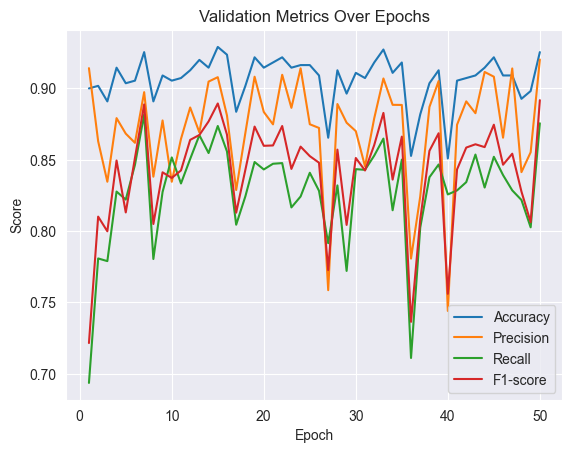

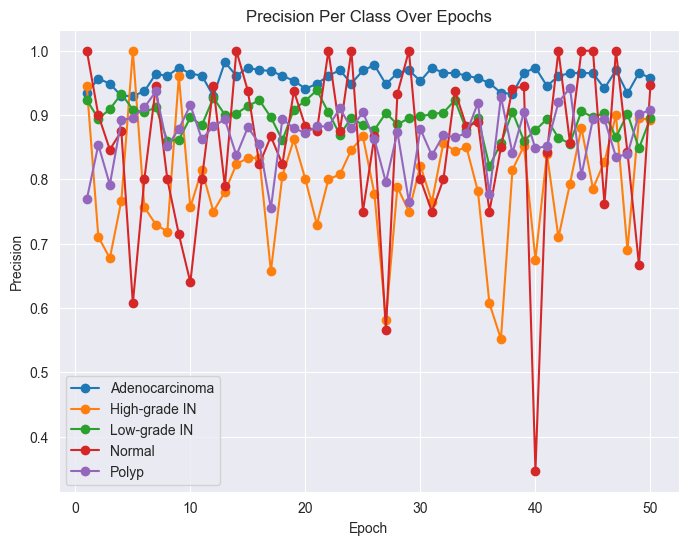

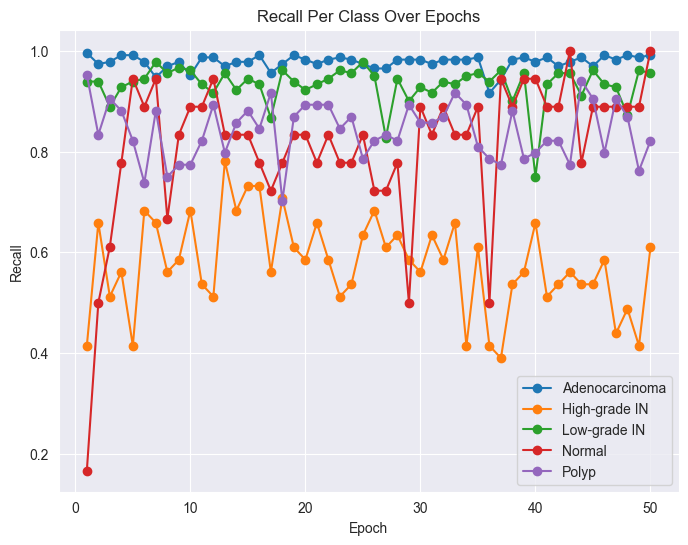

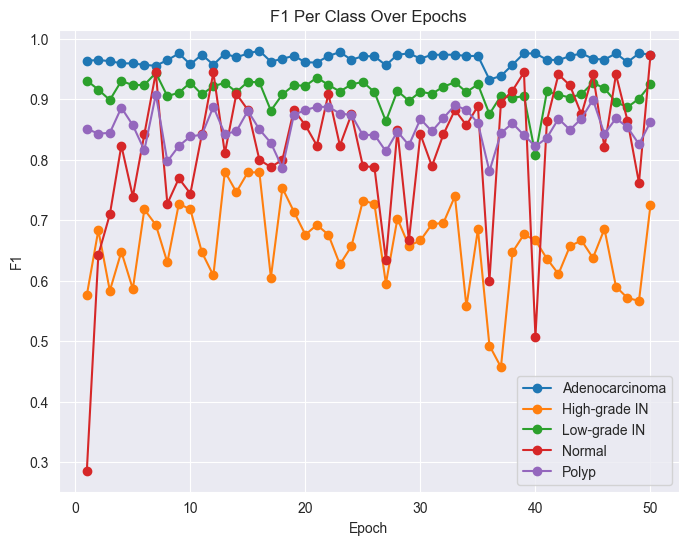

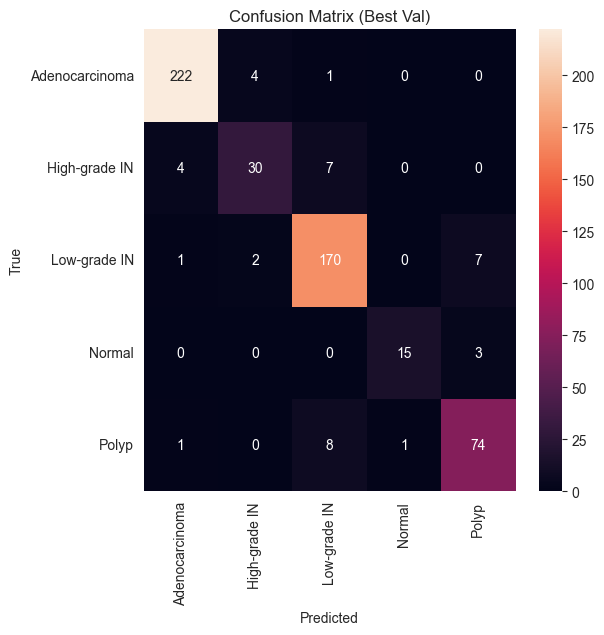

In [10]:
import sys, os

# clear Jupyter's own args
sys.argv = sys.argv[:1]

dataset_path = os.path.abspath(os.path.join(os.getcwd(), "dataset"))
if not os.path.isdir(dataset_path):
    raise RuntimeError(f"❌ Dataset folder not found at {dataset_path}")

sys.argv += [
    "--data_dir", dataset_path,
    "--epochs", "50",
    "--batch_size", "32",
    "--lr", "1e-4",
    "--img_size", "256",
    "--optimizer", "adam",
    "--num_workers", "4",
    "--save_dir", "runs",
    "--loss", "focal+tversky",  # ✅ matches parser
]

print("Launching with:", sys.argv[1:])
main()


In [52]:
sys.argv = sys.argv[:1]
sys.argv += [
    "--data_dir", "datasetrebased",
    "--epochs", "30",
    "--batch_size", "16",
    "--lr", "1e-4",
    "--img_size", "256",
    "--optimizer", "adam",
    "--num_workers", "4",
    "--save_dir", "runs",
    "--loss", "focal+tversky",
    "--model", "densenet"  # ✅ Choose model dynamically
]
main()

✅ Using dataset: datasetrebased
Classes: ['Adenocarcinoma', 'High-grade IN', 'Low-grade IN', 'Normal', 'Polyp']
🧠 Training DENSENET | Loss: focal+tversky


Epoch 1/30 [Train]: 100%|██████████| 277/277 [01:06<00:00,  4.19batch/s, loss=0.1464, acc=0.8086]


[Train] Epoch 1: Loss=0.2519, Acc=0.8086


Epoch 1/30 [Val]: 100%|██████████| 35/35 [00:11<00:00,  3.04batch/s, loss=0.6049, acc=0.8662]


[Val] Epoch 1: Acc=0.8662, Precision=0.7664, Recall=0.7046, F1=0.7246
✅ Best model updated at epoch 1 with Acc=0.8662


Epoch 2/30 [Train]:  31%|███       | 86/277 [00:26<00:38,  4.98batch/s, loss=0.0763, acc=0.9174]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000282DE21A950>
Traceback (most recent call last):
  File "D:\Anaconda\envs\yolo5\lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "D:\Anaconda\envs\yolo5\lib\site-packages\torch\utils\data\dataloader.py", line 1568, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "D:\Anaconda\envs\yolo5\lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "D:\Anaconda\envs\yolo5\lib\multiprocessing\popen_spawn_win32.py", line 108, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
KeyboardInterrupt: 
Epoch 2/30 [Train]: 100%|██████████| 277/277 [01:37<00:00,  2.84batch/s, loss=0.0234, acc=0.9134]


[Train] Epoch 2: Loss=0.1263, Acc=0.9134


Epoch 2/30 [Val]: 100%|██████████| 35/35 [00:08<00:00,  3.92batch/s, loss=0.5093, acc=0.8770]


[Val] Epoch 2: Acc=0.8770, Precision=0.7988, Recall=0.7633, F1=0.7770
✅ Best model updated at epoch 2 with Acc=0.8770


Epoch 3/30 [Train]:  66%|██████▋   | 184/277 [00:43<00:22,  4.21batch/s, loss=0.1601, acc=0.9453]


KeyboardInterrupt: 

In [ ]:

sys.argv = sys.argv[:1]
sys.argv += [
    "--data_dir", "dataset",
    "--epochs", "30",
    "--batch_size", "16",
    "--lr", "1e-4",
    "--img_size", "256",
    "--optimizer", "adam",
    "--num_workers", "4",
    "--save_dir", "runs",
    "--loss", "focal+tversky",
    "--model", "efficientnet"  # ✅ Choose model dynamically
]
main()